In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import pandas as pd
import numpy as np
import h5py
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import warnings

# 모든 FutureWarning 무시
warnings.simplefilter(action='ignore', category=FutureWarning)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2025-05-06 13:42:12.183184: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746538932.195651   17314 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746538932.201412   17314 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


- Histology patch 이미지를 통해서 어느 슬라이드 인지 구분할 수 있는지 확인해봅니다.

# Data Processing

In [2]:
def load_data(filename):
    """
    이미지를 불러옵니다.
    Parameters:
        filename: str
            h5 파일에서 데이터를 불러옵니다.
    Returns:
        np.ndarray, pd.DataFrame, np.ndarray, 
        train 이미지, train spot 정보, test 이미지, test spot 정보
    """
    images, spots = list(), list()
    with h5py.File(filename, "r") as h5file:
        train_images = h5file["images/Train"]
        train_spots = h5file["spots/Train"]
    
        num_train_slides = len(train_images)
        # Train 이미지를 불러옵니다.
        # 하나의 텐서로 만들기 위해 이미지의 크기를 2000x2000으로 균일하게 만듭니다.
        for i, slide_name in enumerate(train_images.keys()):
            image = (np.array(train_images[slide_name]) * 255).astype('uint8')
            p1 = 2000 - image.shape[0]
            p2 = 2000 - image.shape[1]
            images.append(
                np.pad(image, [(0, p1), (0, p2), (0, 0)], 'edge')
            )
            spots.append(pd.DataFrame(np.array(train_spots[slide_name])).assign(slide = i))
            if slide_name == 'S_2':
                spots[-1] = spots[-1].assign(
                    x = lambda x: x['x'] - 60,
                    y = lambda x: x['y'] - 60,
                )
        # Test 이미지를 불러옵니다.
        test_images = h5file["images/Test"]
        test_spots = h5file["spots/Test"]
        sample = 'S_7'
        image = (np.array(test_images[sample]) * 255).astype('uint8')
        p1 = 2000 - image.shape[0]
        p2 = 2000 - image.shape[1]
        images.append(np.pad(image, [(0, p1), (0, p2), (0, 0)], 'edge'))
        spots.append(pd.DataFrame(np.array(test_spots[sample])).assign(slide = len(spots)))
    # EfficientNet의 형식으로 바꿉니다.
    with tf.device('/CPU:0'):
        images = tf.constant(tf.keras.applications.efficientnet.preprocess_input(images))
    df_spots = pd.concat(spots).reset_index(drop = True)
    return images, df_spots

def make_img_proc_info(df, img_with, img_height):
    return df.assign(
        left = lambda x: x['x'] - img_width // 2,
        right = lambda x: x['x'] + img_width // 2,
        top = lambda x: x['y'] - img_height // 2,
        bottom = lambda x: x['y'] + img_height // 2,
        lpad = lambda x: -(x['left'].where(x['left'] < 0, 0)),
        rpad = lambda x: -(2000 - x['right']).where(x['right'] > 2000, 0),
        tpad = lambda x: -(x['top'].where(x['top'] < 0, 0)),
        bpad = lambda x: -(2000 - x['bottom']).where(x['bottom'] > 2000, 0)
    ).assign(
        left = lambda x: x['left'].clip(0, 2000),
        right = lambda x: x['right'].clip(0, 2000),
        top = lambda x: x['top'].clip(0, 2000),
        bottom = lambda x: x['bottom'].clip(0, 2000),
    )

def create_tf_ds(df):
    if target in df.columns:
        return tf.data.Dataset.from_tensor_slices(
            ({
                i: df[i] for i in ['left', 'right', 'top', 'bottom', 'slide', 'lpad', 'rpad', 'tpad', 'bpad']
            }, df[target])
        )
    else:
        return tf.data.Dataset.from_tensor_slices({
            i: df[i] for i in ['left', 'right', 'top', 'bottom', 'slide', 'lpad', 'rpad', 'tpad', 'bpad']
        })

def proc_images(X, images):
    return tf.cast(tf.pad(
        images[X['slide'], X['left']:X['right'], X['top']:X['bottom'], :], 
        paddings = [(X['lpad'], X['rpad']), (X['tpad'], X['bpad']), (0, 0)],
        constant_values=1
    ), tf.float32) / 255.0

augmentation_layers = [
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.5),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x

images, df_spots = load_data("data/elucidata_ai_challenge_data.h5")
target = 'slide'

I0000 00:00:1746538936.878109   17314 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


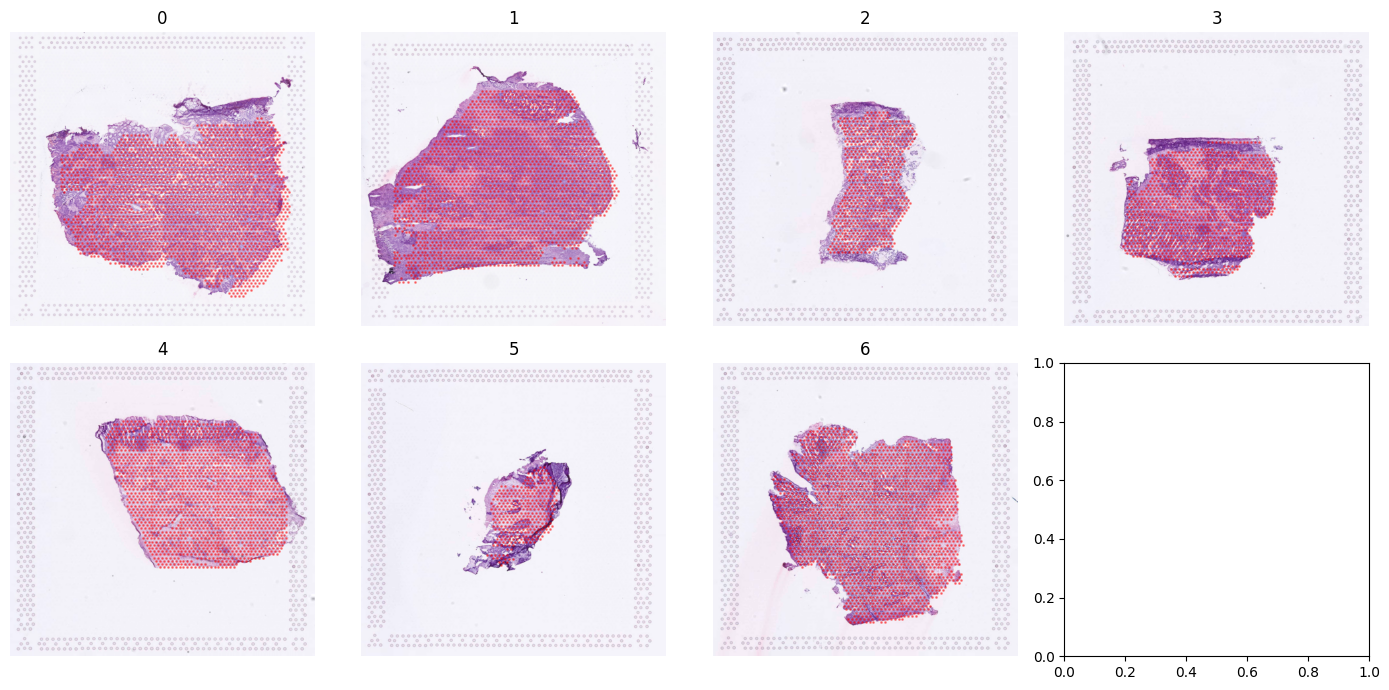

In [3]:
fig, ax = plt.subplots(2, 4, figsize=(14, 7))
ax = ax.flatten()
for i, slide_name in enumerate(range(7)):
    image = images[i]
    x, y = df_spots.loc[df_spots['slide'] == i, "x"], df_spots.loc[df_spots['slide'] == i, "y"]

    ax[i].imshow(image, aspect="auto")
    ax[i].scatter(x, y, color="red", s=1, alpha=0.4)  # Overlay spot locations
    ax[i].set_title(slide_name)
    ax[i].axis('off')

plt.tight_layout()
plt.show()

In [4]:
from scipy.stats import spearmanr

def create_model(img_width, img_height):
    input_shape = (img_width, img_height, 3)
    inputs = tf.keras.Input(shape = input_shape)
    enet_, _ = joblib.load('model/ae_encoder_b0_obj.joblib')
    enet = tf.keras.applications.EfficientNetB0(
        include_top = False, 
        #weights = 'imagenet',
        input_shape = input_shape,
        pooling = 'avg'
    )
    enet.set_weights(enet_)
    enet.trainable = True
    """
    for i in enet.layers:
        if not isinstance(i, tf.keras.layers.BatchNormalization):
            i.trainable = True
    """
    x = enet(inputs)
    #x = tf.keras.layers.Dropout(0.5)(x)
    d1 = tf.keras.layers.Dense(
        256, activation = 'relu', 
        kernel_initializer = 'HeUniform'
    )
    x = d1(x)
    d2 = tf.keras.layers.Dense(df_spots['slide'].nunique())
    outputs = d2(x)
    m = tf.keras.models.Model(inputs, outputs)
    return m, (enet, d1, d2)

In [5]:
from sklearn.model_selection import GroupKFold, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
img_width = 224
img_height = 224
df_spots = make_img_proc_info(df_spots, img_width, img_height)

gkf = GroupKFold(n_splits = 6)
ssf = StratifiedShuffleSplit(n_splits=1, train_size = 0.8)
scores = list()
oofs = list()
for i, (train_idx, valid_idx) in enumerate(
    ssf.split(df_spots[['x', 'y']], df_spots[target])# , groups = df_spots['slide'])
):
    break
m, layers = create_model(img_width, img_height)
m.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,379,306 (16.71 MB)

 Trainable params: 4,337,283 (16.55 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [6]:
from sklearn.metrics import accuracy_score
learning_rate = 1e-3
#target_proc = FunctionTransformer(lambda x: x, lambda x: x)
batch_size = 32
epochs = 20
step = ''
ds_cv_train = create_tf_ds(
    df_spots.iloc[train_idx].pipe(
        lambda x: pd.concat([
            x, x.sample(n = batch_size - (len(x) % batch_size))
        ])
    )
).shuffle(5000).map(
    lambda X, y: (proc_images(X, images), y)
).map(
    lambda X, y: (data_augmentation(X), y)
).batch(batch_size)


if valid_idx is not None:
    ds_valid = create_tf_ds(df_spots.iloc[valid_idx]).map(
        lambda X, y: (proc_images(X, images), y)
    ).batch(batch_size)
else:
    ds_valid = None
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=learning_rate,
    decay_steps=3000,
    alpha=0.1
)
#    lr_schedule = learning_rate
m.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

hist = m.fit(ds_cv_train, epochs = epochs, validation_data = ds_valid)

Epoch 1/20


I0000 00:00:1746427444.829275    1600 service.cc:148] XLA service 0x7f95b8014dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746427444.829309    1600 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
I0000 00:00:1746427447.286380    1600 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1746427454.504299    1600 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746427454.818731    1600 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746427455.008409    1600 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1

261/261 ━━━━━━━━━━━━━━━━━━━━ 133s 289ms/step - loss: 0.7140 - sparse_categorical_accuracy: 0.7264 - val_loss: 2.0075 - val_sparse_categorical_accuracy: 0.6944
Epoch 2/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 103s 259ms/step - loss: 0.2110 - sparse_categorical_accuracy: 0.9215 - val_loss: 1.7570 - val_sparse_categorical_accuracy: 0.6274
Epoch 3/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 69s 266ms/step - loss: 0.1418 - sparse_categorical_accuracy: 0.9480 - val_loss: 0.1444 - val_sparse_categorical_accuracy: 0.9468
Epoch 4/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 68s 258ms/step - loss: 0.1165 - sparse_categorical_accuracy: 0.9607 - val_loss: 0.8001 - val_sparse_categorical_accuracy: 0.8180
Epoch 5/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 68s 262ms/step - loss: 0.0837 - sparse_categorical_accuracy: 0.9705 - val_loss: 0.9816 - val_sparse_categorical_accuracy: 0.8386
Epoch 6/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 70s 266ms/step - loss: 0.0873 - sparse_categorical_accuracy: 0.9695 - val_loss: 1.7407 - val_sparse_categorical_accuracy: 0.